In [416]:
import scipy as sp
import scipy.optimize as op
import numpy as np
import pylab as pl
from scipy.special import erfc
from scipy.signal import find_peaks_cwt
%matplotlib inline

In [403]:
#set starting values for parameters that should be constant across the peaks i.e. the peak shapes
#Shape of the peak defined by the width sigma, tail height r, and tail decay constant beta.
sig = 4.
r = 15.
beta = 15.

lb = 900
ub = 1000

#default bounds for A and mu
#A can't be less than 0 (yay the upside down peaks that you sometimes get in gf3 are no more)
#mu unbounded - can be anywhere on the spectrum
bnd = ((0.,None), (None,None), )
#bounds for metaparameters sigma, r, and beta (they are 'meta' because they should remain constant across peaks locally)
#set sigma bound at the resolution of the detector - it's about 4 channels for Munich using the binning that I am
#This can change though. I've set the upper bound to 10 channels just so it doesn't try to fit the background
#It can't be negative either
#R can only be between 0 and 100 since it's a percentage of the height
#Beta can be any positive number
metabnd = ((0.1,10), (0.1, 100), (0.1,None))

In [404]:
#Define gf3 function
def gf3(p0, x):
    #this is the fuctional form that we have been using in our manual fit
    #it is the sum of a gaussian and a skewed gaussian with the same mean
    #the extra parameters r and beta are introduced
    #r is the fraction of the height of the skewed gaussian given as a pecentage
    #beta is the 'skewneess' of the second skew gaussian
    #it is the decay constant of an exponential tail on the skewed gaussian
    #this exponential tail is convolved with a gaussian resolution function
    
    amp, mu, sigma, r, beta = p0
    
    
    #gaussian part
    ygaus = amp * (1 - r/100) * np.exp((-(x - mu)**2)/(2 * sigma**2))
    
    #'skew' gaussian part. erfc is 1 - the error function
    yskew = amp * (r/100) * np.exp((x-mu)/beta) * erfc( (x-mu)/(sigma * np.sqrt(2))  + sigma/(beta*np.sqrt(2)))
    #yskew = 0
    #ygaus = 0
    ymod = yskew + ygaus
    
    return ymod

#define log likelihood, the thing we want to maximise
def lnlike(p0, x, y):
    
    # get model for these parameters:
    npeaks = int((len(p0)-3)/2)
    ymod = 0
    for i in range(npeaks):
        p1 = [p0[i * 2], p0[i * 2 + 1], p0[-3], p0[-2], p0[-1]]
        ymod += gf3(p1,x)
    
    # Poisson loglikelihood:
    ll = np.sum(ymod[np.where(y!=0)]*np.log(y[np.where(y!=0)])) - np.sum(y) - np.sum(ymod[np.where(ymod!=0)]*np.log(ymod[np.where(ymod!=0)]) - ymod[np.where(ymod!=0)])
    
    return ll


In [405]:
#read in the file
filename = 'run567.txt'
infile = open(filename,'r')

xvals2=[];ymeas2=[]
while True:
    line = infile.readline()
    if not line: break
        
    items = line.split()
    xvals2.append(float(items[0]))
    ymeas2.append(float(items[1]))

infile.close()

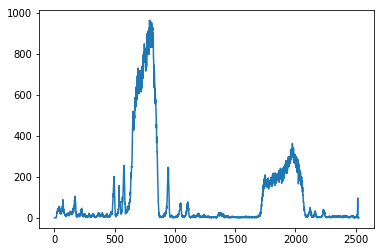

In [406]:
#convert to numpy arrays and plot to see what it looks like
xvals2 = np.array(xvals2)
ymeas2 = np.array(ymeas2)

ymeas2[0] = 0
#ymeas2[440:700] = 0
pl.plot(xvals2,ymeas2)
pl.show()

In [407]:
#set the indices for the template xvalues. Annoyingly, the index doesn't correspond exactly to the x values
lb2 = np.where(xvals2 > lb)
ub2 = np.where(xvals2 < ub)

inds = np.intersect1d(lb2,ub2)
ub2 = np.max(inds)
lb2 = np.min(inds)

print(lb2,ub2)

891 990


#Object Detection

[241.97585427 943.99089058   5.57622488  16.9987972   16.47310526]


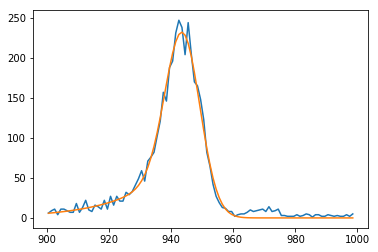

In [408]:
#Acquire Template
#template position is hard coded in, can't see easy way to select it before getting rid of the contaminants
xtemp = np.array(xvals2[lb2:ub2])
ytemp = np.array(ymeas2[lb2:ub2])
pl.plot(xtemp,ytemp)

#finding the amplitude and position of the peak
mutemp = xtemp[np.argmax(ytemp)]
Atemp = np.max(ytemp)

#set initial conditions for template
ptemp0 = [Atemp, mutemp, sig, r, beta]
bndstemp = (bnd[0], bnd[1], metabnd[0], metabnd[1], metabnd[2])

nll = lambda *args: -lnlike(*args)

result = op.minimize(nll, ptemp0, bounds=bndstemp, args=(xtemp, ytemp))
ptemp1 = result["x"]

ytemp = gf3(ptemp1,xtemp)
print(ptemp1)

pl.plot(xtemp,ytemp)
pl.show()

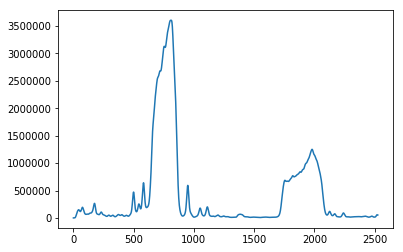

2485 2485


In [409]:
#Take cross-correlation of template with spectrum for a matched filter
#this smoothes out a lot of the noisiness of the peaks and gets rid of any baseline noise left
ymatched = np.convolve(ymeas2,np.flip(ytemp, axis=0), 'same')
pl.plot(xvals2, ymatched)
pl.show()

print(len(ymatched), len(ymeas2))

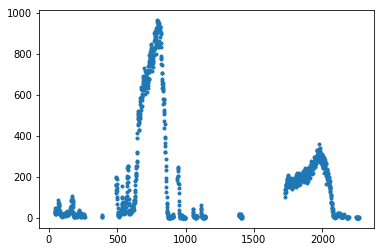

In [410]:
#going to fit regions separately
#my first criterion for object detection is a simple threshold in the matched filter range
#the background is really flat in this range so if the value is bigger than a set percentile, it must be in a system of peaks

ythresh = []
xthresh = []

#get a set of indices where the y value in the matched range is bigger than the median
#adding beta to this to counter the offset of the peak in the matched range due to the skew
threshix = np.array(np.where(ymatched > np.percentile(ymatched, 50)))[0] + int(round(ptemp1[4]))# + 4 * int(round(ptemp1[2] ))))


#now get the values from the raw data range and stick them on a list
for i in threshix:
    if i < len(xvals2):
        ythresh.append(ymeas2[i])
        xthresh.append(xvals2[i])

#numpyfy
xthresh = np.array(xthresh)
ythresh = np.array(ythresh)
 
#this is what it looks like
pl.plot(xthresh, ythresh, '.')
pl.show()

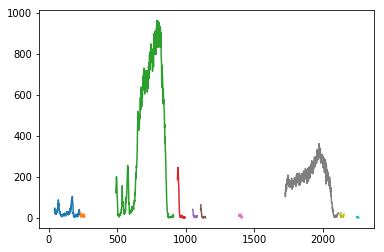

In [411]:
#now separate these into different objects to be fitted separately
fitting_regions = []

#have these temporary lists to push x and y values onto
xreg = []
yreg = []


for i in range(len(xthresh)):
    xreg.append(xthresh[i])
    yreg.append(ythresh[i])
    
    
    if i != len(xthresh) - 1: #checking we aren't at the end of the array
        if xthresh[i] != xthresh[i+1] - 1:
            if len(xreg) > ptemp1[4]: #make sure these regions are actually big enough to fit, wider than the template peak width
                fitting_regions.append([xreg,yreg])
            #clean these temporary things up
            xreg = []
            yreg = []

for x,y in fitting_regions:
    pl.plot(x,y)

In [412]:
#this section is basically an aside in case you want to know what peaks it's finding in the matched and raw ranges
#to check it's working properly
#change the peak by changing 
#                      \ this number and the one below it
ypre = fitting_regions[10][1]
xpre = fitting_regions[10][0]

fig = pl.figure()

ax1 = fig.add_subplot(121)
ax1.plot(xpre,ypre)


ytest = np.convolve(np.flip(ytemp, axis=0),ypre, 'same')
pos = find_peaks_cwt(ytest, widths = np.full(len(ymatched),ptemp1[2]))
pos2 = find_peaks_cwt(ypre, widths = np.full(len(ymatched),ptemp1[2]))

#print(min(fitting_regions[1][0]) + ptemp1[4] + pos/200 * len(fitting_regions[2][0]))
print(pos)

for pos in pos2:
    print(xpre[pos])

ax2 = fig.add_subplot(122)
ax2.plot(np.arange(191), ytest)

fig.tight_layout()
fig.show()

IndexError: list index out of range

[49.0, 45.5, 89.0, 70.5, 33.0, 131.5, 106.0, 170.5, 42.0, 220.5, 5.576224875635042, 16.99879720494727, 16.473105259195197]
[ 32.34814338  37.64438691  59.95797589  71.00834944   2.26248594
 131.68174815  90.4379758  170.20589742  47.71036683 227.55855272
   5.01183382  16.35768238  71.88010289]
5


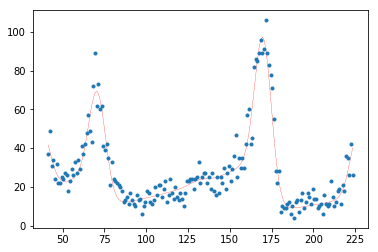



[19.0, 245.5, 5.576224875635042, 16.99879720494727, 16.473105259195197]
[  6.26454672 262.63329581   6.76511757  99.99972845 997.67257243]
1


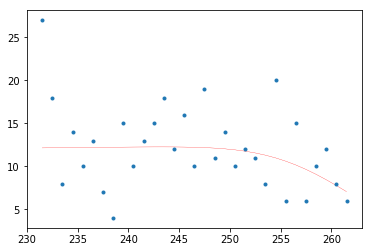



[202.0, 494.5, 158.0, 537.5, 256.0, 576.5, 520.0, 651.5, 731.0, 690.5, 849.0, 745.5, 960.0, 796.5, 933.0, 815.5, 631.0, 841.5, 5.576224875635042, 16.99879720494727, 16.473105259195197]
[ 315.72379217  489.56831887   24.67648178  543.91897807  133.18337107
  583.86567835  551.59633827  674.39211335  723.1120109   710.08331588
  814.79653709  748.1378613   842.40706824  783.25159983 1005.11437783
  816.47986449  725.50900817  847.56609852   10.           99.52162624
   18.84693347]
9


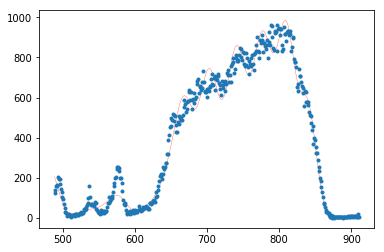



[247.0, 944.5, 5.576224875635042, 16.99879720494727, 16.473105259195197]
[241.47797044 943.28879024   5.7868157    2.38284597   1.76709056]
1


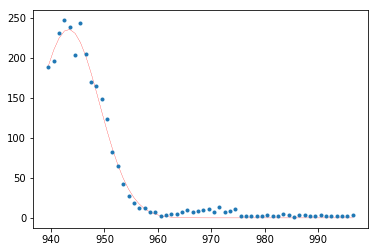



[43.0, 1054.5, 12.0, 1082.5, 5.576224875635042, 16.99879720494727, 16.473105259195197]
[1.00067323e+03 1.02643736e+03 3.37332881e+02 1.11343193e+03
 1.00000000e+01 8.70510976e-01 3.91294657e+02]
2


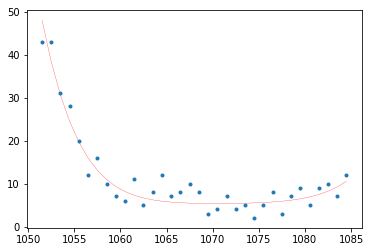



[65.0, 1113.5, 8.0, 1139.5, 5.576224875635042, 16.99879720494727, 16.473105259195197]
[  61.115729   1108.77706571    5.22062738 1140.55159326    4.95601709
   26.18546475  553.51721393]
2


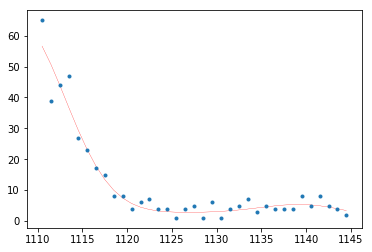



[19.0, 1395.5, 5.576224875635042, 16.99879720494727, 16.473105259195197]
[  16.72819542 1395.20120853    7.80997088    5.78756366   11.37623725]
1


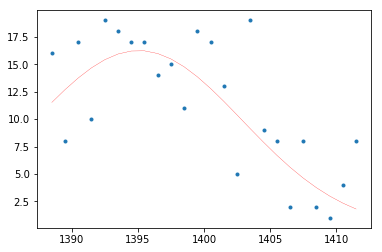



[210.0, 1747.5, 218.0, 1814.5, 242.0, 1874.5, 280.0, 1919.5, 363.0, 1976.5, 292.0, 2017.5, 237.0, 2035.5, 234.0, 2039.5, 5.576224875635042, 16.99879720494727, 16.473105259195197]
[  21.15231187 1765.24977767    0.         1797.2688357    22.78651264
 1824.80202312   19.20324643 1875.76780014    9.75218978 1929.91808158
   65.61341318 1991.09779708   70.27631462 2032.72044609   93.78616794
 2066.29657716   10.           99.9776034   163.47524424]
8


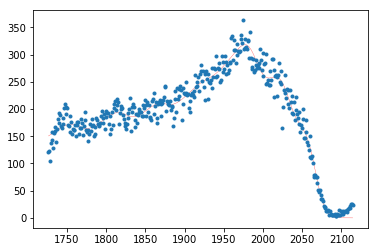



[27.0, 2131.5, 21.0, 2153.5, 5.576224875635042, 16.99879720494727, 16.473105259195197]
[2.25484964e+01 2.13246381e+03 2.27151302e+01 2.15630038e+03
 6.96820021e-01 2.19150965e+01 3.46072133e+01]
2


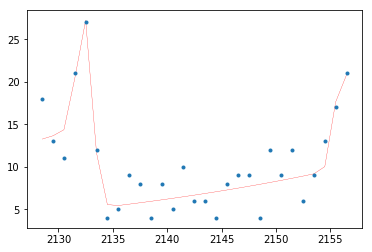



[4.0, 2260.5, 5.576224875635042, 16.99879720494727, 16.473105259195197]
[2.75321036e+00 2.25917144e+03 1.00000000e+01 1.00000000e+02
 5.33472961e+03]
1


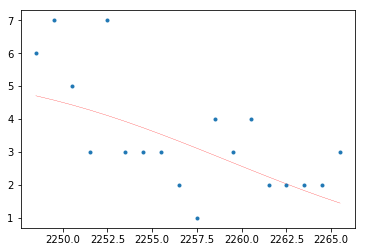

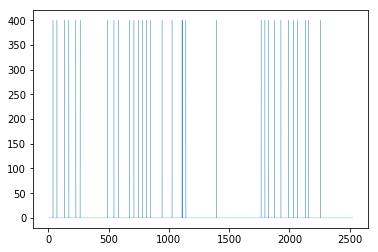

In [415]:
#now to actually going through and fitting everything
#first of all want the spectrum to compare it to
#pl.plot(xvals2, ymeas2, lw = 0.1)#, '.', markersize = 0.25)

#initialise lists to attach the fitted traces to
yfits = []
mets = [ptemp1[2], ptemp1[3], ptemp1[4]]

peakpos = []

#get fits for each region
for x,y in fitting_regions:
    x = np.array(x)
    y = np.array(y)
    #matched filter each peak
    ymatch = np.convolve(np.flip(ytemp, axis=0),y, 'same')
    
    #work out the number of peaks by looking at the matched filtered spectrum
    nopeaks = len(find_peaks_cwt(ymatch, widths = np.full(len(ymatch),ptemp1[2])))
    
    #initialise a peak position list by using find_peaks_cwt on the unmatched peaks
    #this should either be correct or contain some peaks from noise
    positions = find_peaks_cwt(y, widths = np.full(len(y),ptemp1[2]))
    
    #this loop deletes the lowest "peak" in the positions list until the number of peaks is correct
    #i.e. equal to the number of peaks found in the matched filtered spectrum
    #this approach assumes that the reason it's finding extra peaks is due to low lying noise
    #which was correct for Munich February run 562, should be tested on other spectra
    
    
    while nopeaks != len(positions):
        #find the y values of the initial guesses of where the peaks are
        peaks = []
        for peak in positions:
            peaks.append(y[peak])
        
        #which one is the minimum
        try:
            ixmin = int(np.where(peaks == np.min(peaks))[0])
        except TypeError: #if there's two "minimum" peaks of the same height, just delete the first one
            ixmin = int(np.where(peaks == np.min(peaks))[0][0])
        #delete the lowest lying peak
        positions = np.delete(positions,ixmin)
     
    #now have peak positions, need amplitudes.    
    peakparams = []

    for position in positions:
        lowerbound =  max([int(round(position - ptemp1[2])), 0])
        upperbound = min([int(round(position + ptemp1[2])), max(x)])
        amplitude = max(y[lowerbound:upperbound])
        #put the position and corresponding amplitude on to "peakparams" like this since we want to unpack them at the same time
        p = [position, amplitude]
        peakparams.append(p)

    
    #now need bounds
    bnds = []
    for peak in positions:
        for bound in bnd:
            bnds.append(bound)

    for bound in metabnd:
        bnds.append(bound)
    
    #now get the initial parameters for the fit
    p0 = []

    for pos, amp in peakparams:
        p0.append(amp)
        p0.append(pos + min(x)) #adding the min since the pos is only relative to the start of the x array
        
    for param in mets:
        p0.append(param)
        
    
    
    #run through the optimiser
    result = op.minimize(nll, p0, bounds=bnds, args=(x,y))
    p1 = result["x"]
    
    #print out some stuff to see how it went
    print(p0)
    print(p1)
    print(nopeaks)
    
    #build up the model from all of the different peaks in the fit
    ymod = 0
    for i in range(nopeaks):
        p2 = [p1[i * 2], p1[i * 2 + 1], p1[-3], p1[-2], p1[-1]]
        ymod += gf3(p2,x)
        peakpos.append(np.round(p2[1]))
        #print(p2[1])
        #print(np.round(p2[1]))
    
    #plot each fit
    pl.plot(x, ymod, 'r', lw = 0.25)
    pl.plot(x,y, '.') #this is in case you want a plot of each fit in detail
    pl.show() #so is this
    
    yfits.append(ymod)
    
    
    print('\n')

ypeaks = np.full(len(xvals2),0)

for value in xvals2:
    for pos in peakpos:
        #print(value)
        #print(pos)
        if value == pos + 0.5:
            #print(pos)
            #if pos < len(ymeas2):
            ypeaks[np.where(xvals2 == pos + 0.5)] = 400
pl.plot(xvals2, ypeaks, lw = 0.25)
#pl.savefig('autofit.png', dpi = 1000)